#  EM (Expectation-Maximization) algorithm applied to Gaussian Mixtures

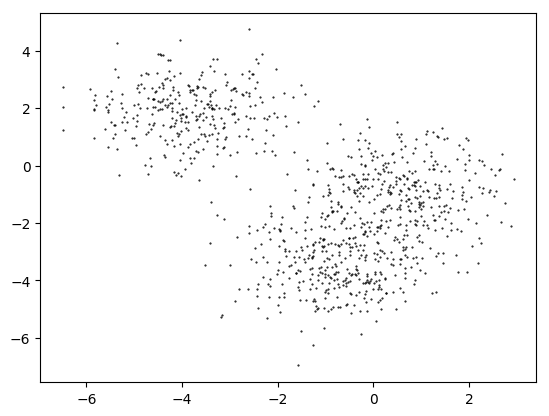

2×1000 Array{Float64,2}:
 0.818943  -5.47024  -3.64448   0.902104  …  -0.853131  -4.29491  -2.7459 
 0.446734   2.31739   1.73176  -2.48227      -0.125346   3.67507   2.47872

In [1]:
using PyPlot
# number of data points
N = 1000
# number of dimensins
n = 2
# generate random data
srand(1234)
x = randn(n,N)
k = 3
xc_true = 3 * randn(n,k)

for i = 1:N
    ic = rand(1:k)
    x[:,i] = xc_true[:,ic] + randn(2)
end

plot(x[1,:],x[2,:],"k.",markersize = 1);
x

$$\newcommand{\vec}{\mathbf}\newcommand{\mat}{\mathbf}$$

A Gaussian pdf is given by its mean $\vec \mu$ and its covariance matrix $\mat \Sigma$

$$
p(\vec x) = \frac{1}{\sqrt{2\pi \det(\mat \Sigma)}} \exp\left(-\frac{1}{2} (\vec x - \vec μ)^T  \mat Σ^{-1} (\vec x - \vec μ) \right)
$$

In [2]:
Gaussian(x,μ,Σ) =  1/(sqrt(2π * det(Σ))) * exp(- (x - μ)' * (Σ \ (x - μ) )/2 )

Gaussian (generic function with 1 method)

A gaussian mixture model is a linear combination of Gaussians

$$
p'(\vec x) = \sum_{l=1}^k \frac{\phi_l}{\sqrt{2\pi \det(\mat \Sigma_l)}} \exp\left(-\frac{1}{2} (\vec x - \vec μ_l)^T  \mat Σ_l^{-1} (\vec x - \vec μ_l) \right)
$$

where all coefficients $\phi_l$ are positive and their sum is 1.

In [3]:
function GMM(x,ϕ,μ,Σ)
    GMM = 0.
    for l = 1:size(μ,2)
        GMM += ϕ[l] * Gaussian(x,μ[:,l],Σ[:,:,l])
    end
    
    return GMM
end

GMM (generic function with 1 method)

An example

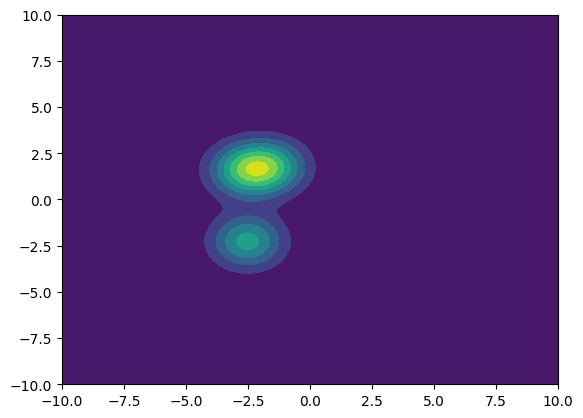

In [4]:
# initialize
n = 2
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

gx = linspace(-10,10,100);
gy = linspace(-10,10,100);

p = zeros(length(gx),length(gy));
pk = zeros(length(gx),length(gy),k);

for j = 1:length(gy)
    for i = 1:length(gx)
        p[i,j] = GMM([gx[i]; gy[j]],ϕ,μ,Σ);
        for l = 1:k
            pk[i,j,l] = Gaussian([gx[i]; gy[j]],μ[:,l],Σ[:,:,l]); 
        end
    end
end


contourf(gx,gy,p');

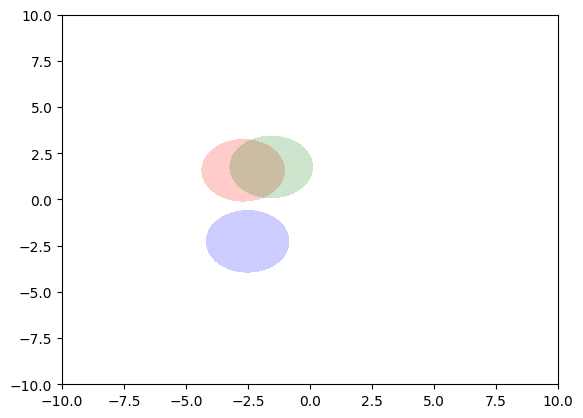

In [5]:
function plotGaussian(μ,Σ,color)
    gx = linspace(-10,10,100);
    gy = linspace(-10,10,100);

    p = zeros(length(gx),length(gy));
    #@show μ
    for j = 1:length(gy)
        for i = 1:length(gx)
            p[i,j] = Gaussian([gx[i]; gy[j]],μ,Σ); 
        end
    end
    
    contourf(gx,gy,p',levels = [0.1,100],colors=color,alpha=0.2)
end
    
function plotGaussians(μ,Σ,colors = ["r","g","b","c"])
    for l = 1:size(μ,2)
        plotGaussian(μ[:,l],Σ[:,:,l],colors[l])
    end
end

plotGaussians(μ,Σ)

Sampling from a gaussian mixture
* choose a $z$, an integer number from 1 to $k$. The probability of choosing $z = j$ is $\phi_j$ ($1 \le j \le k$).
* sample from the Gaussian distribution with mean $\vec \mu_j$ and covariance $\mat \Sigma_j$ where $j = z$.


As the data is unlabeld, we do not known from which Gaussian a particular data point is sampled from: $z$ is thus unknown.


## Expectation step

For each sample $i$ and Gaussian $j$, compute the weights $w^{(i)}_j$ wich corresponds to the probability that the sample
$ \vec x^{(i)}$ comes from the Gaussian $j$

$$
w^{(i)}_j = P(z^{(i)} = j \mid \vec x^{(i)})
$$

The Bayes rule allows us to compute these weights:


$$\begin{eqnarray} 
P(z^{(i)} = j \mid \vec x^{(i)}) &=& \frac{P(\vec x^{(i)} \mid z^{(i)} = j) \; P(z^{(i)} = j) } {\sum_{l=1}^k P(\vec x^{(i)} \mid z^{(i)} = l) \; P(z^{(i)} = l) }  \\
&=&  \frac{P(\vec x^{(i)} \mid z^{(i)} = j) \; \phi_j } {\sum_{l=1}^k P(\vec x^{(i)} \mid z^{(i)} = l) \; \phi_l }
\end{eqnarray}$$

where

$$
P(\vec x^{(i)} \mid z^{(i)} = j) = 
\frac{1}{\sqrt{2\pi \det(\mat \Sigma_j)}}
\exp\left(-\frac{1}{2} (\vec x - \vec μ_j)^T  \mat Σ_j^{-1} (\vec x - \vec μ_j) \right)
$$


In [6]:
function expectation_step(x,ϕ,μ,Σ)
    k = length(ϕ)
    N = size(x,2)
    w = zeros(k,N)

    for i = 1:N
        for j = 1:k
            w[j,i] = Gaussian(x[:,i],μ[:,j],Σ[:,:,j]) * ϕ[j]
        end
    
        w[:,i] = w[:,i]/sum(w[:,i])
    end

    return w
end

expectation_step (generic function with 1 method)

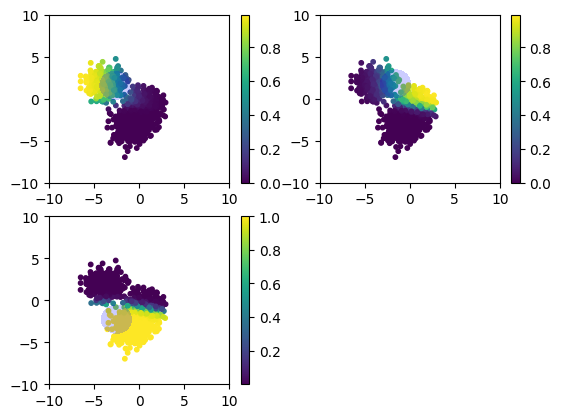

In [7]:
w = expectation_step(x,ϕ,μ,Σ) 

for l = 1:k
    subplot(2,2,l)
    scatter(x[1,:],x[2,:],10,w[l,:]); colorbar();
    plotGaussian(μ[:,l],Σ[:,:,l],"b")
end

Weighted mean assuming the sum of all elements of `wn` is 1.

In [9]:
function wmean(x,wn)
    μ = zeros(size(x,1));
    for i = 1:size(x,2)
       μ += wn[i] * x[:,i]
    end
    return μ
end
function wcovar(x,wn,μ = wmean(x,wn))
    Σ = zeros(length(μ),length(μ));
    for i = 1:size(x,2)
       Σ += wn[i] * (x[:,i] - μ) * (x[:,i] - μ)'
    end
    return Σ
end
    

wcovar (generic function with 2 methods)

## Maximization step

$$
\phi_j = \frac{1}{N} \sum_{i=1}^N  w^{(i)}_j
$$

Weighted mean:

$$
\vec \mu_j =  \frac{1}{ \sum_{i=1}^N  w^{(i)}_j  }  \sum_{i=1}^N  w^{(i)}_j  \vec x^{(i)}
$$

Weighted covariance:

$$
\mat \Sigma_j =  \frac{1}{ \sum_{i=1}^N  w^{(i)}_j  }  \sum_{i=1}^N  w^{(i)}_j  (\vec x^{(i)} - \vec μ_j) (\vec x^{(i)} - \vec μ_j)^T
$$



In [10]:
function maximization_step!(x,w,ϕ,μ,Σ)
    k = length(ϕ)
    N = size(x,2)

    for j = 1:k
        sumw = sum(w[j,:])
        # normalized weights 
        wn = w[j,:]/sumw
        
        ϕ[j] = sumw/N        
        μ[:,j] = wmean(x,wn)
        Σ[:,:,j] = wcovar(x,wn,μ[:,j])
    end
end


maximization_step! (generic function with 1 method)

In [11]:
#maximization_step!(x,w,ϕ,μ,Σ)
size(w)

(3, 1000)

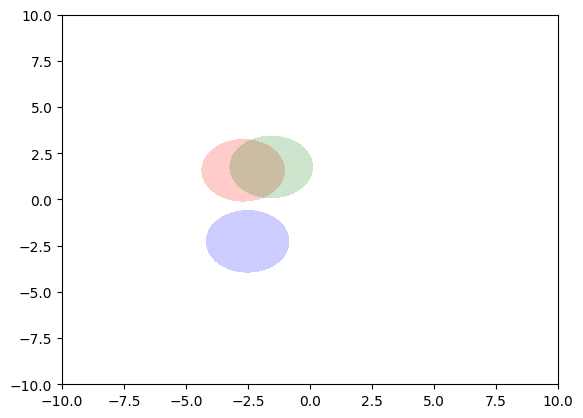

In [12]:
plotGaussians(μ,Σ)


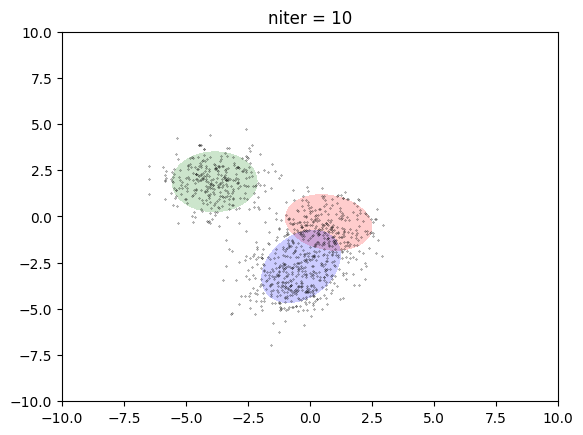

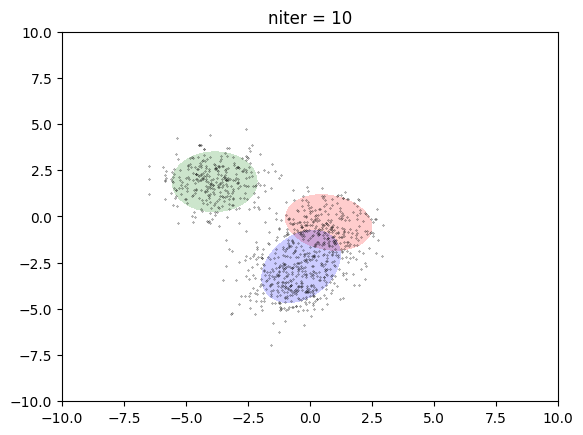

In [15]:
k = 3
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

fig = figure()

for niter = 1:10
    w = expectation_step(x,ϕ,μ,Σ)  

    maximization_step!(x,w,ϕ,μ,Σ)
    
    if niter % 1 == 0
        clf()
        plot(x[1,:],x[2,:],"k.",markersize=0.5)
        plotGaussians(μ,Σ)
        sleep(1)
        title("niter = $(niter)")
        IJulia.clear_output(true)
        display(fig)
    end
end

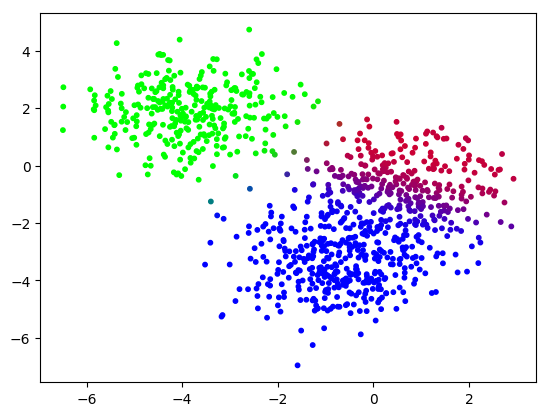

In [17]:
scatter(x[1,:],x[2,:],10,w[1:3,:]'/maximum(w)); 